In [1]:
# homework
# change batch size
# change activation
# change learning rate

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [3]:
# x is for inputs, handwritten digits images
# y is for labels/outputs of digits
# 60k training, 10k test
# 1x28x28 pixels
# outputs/labels, one integer per example
# training data set
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# test data set
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [4]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [5]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


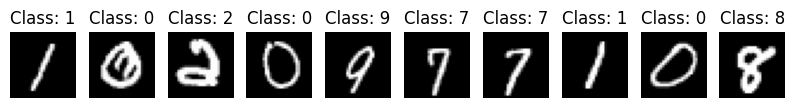

In [6]:
# take closer look, first 10 training digits
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [7]:
# model depending on parameter theta, a loss function j(theta), and an optimization method needed

In [8]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [9]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [10]:
# forward pass, back propagation, weight updates, repeat

In [11]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [12]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [13]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [14]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 1/5, Learning Rate: 0.05
Epoch 0: training loss: 0.5017075227896373, accuracy: 87.5625
Epoch 0: val. loss: 0.4943971373933427, val. accuracy: 87.50833333333333
Epoch 2/5, Learning Rate: 0.005000000000000001
Epoch 1: training loss: 0.4216463753382365, accuracy: 88.97291666666666
Epoch 1: val. loss: 0.4126772148177979, val. accuracy: 88.84166666666667
Epoch 3/5, Learning Rate: 0.005000000000000001
Epoch 2: training loss: 0.41616903972625735, accuracy: 89.05
Epoch 2: val. loss: 0.4070309448115369, val. accuracy: 88.9
Epoch 4/5, Learning Rate: 0.0005000000000000001
Epoch 3: training loss: 0.41199635398387907, accuracy: 89.09375
Epoch 3: val. loss: 0.4028316663300737, val. accuracy: 88.99166666666667
Epoch 5/5, Learning Rate: 0.0005000000000000001
Epoch 4: training loss: 0.41158394229412076, accuracy: 89.10208333333334
Epoch 4: val. loss: 0.40242511509580814, val. accuracy: 89.00833333333334
CPU times: user 14min 7s, sys: 474 ms, total: 14min 7s
Wall time: 38 s


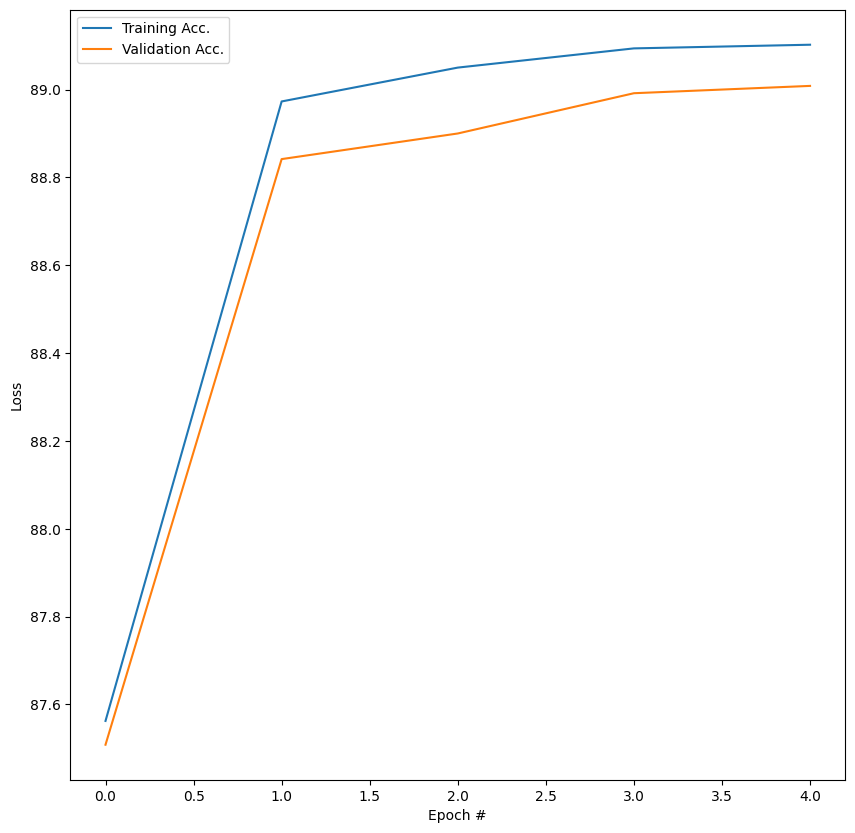

In [15]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

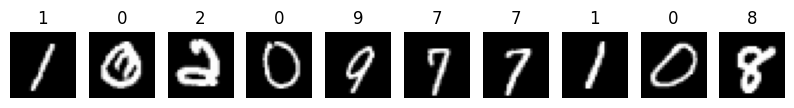

In [16]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

In [17]:
# see how model generalizes unseen test data
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 32 # 64, 128, 256, 512
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [18]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3892, test accuracy: 89.79%


In [19]:
# take a closer look at results
# define helper function to show failure cases of classifier
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


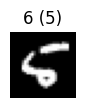

In [20]:
# first 10 images of test data that small model classified into wrong class
show_failures(linear_model, test_dataloader)

In [21]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(), # nn.Tanh, nn.Sigmoid, nn.LeakyReLU
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [22]:
#### For HW: cell to change learning rate

learning_rate = 0.1 # 0.01, 0.001, 0.001
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

In [23]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 1/5, Learning Rate: 0.1
Epoch 0: training loss: 0.5440109368960062, accuracy: 84.57708333333333
Epoch 0: val. loss: 0.5412470844197781, val. accuracy: 84.44166666666668
Epoch 2/5, Learning Rate: 0.010000000000000002
Epoch 1: training loss: 0.32957922252019245, accuracy: 90.58125
Epoch 1: val. loss: 0.3272275100363062, val. accuracy: 90.31666666666666
Epoch 3/5, Learning Rate: 0.010000000000000002
Epoch 2: training loss: 0.299935805439949, accuracy: 91.57499999999999
Epoch 2: val. loss: 0.3001168552548327, val. accuracy: 91.33333333333333
Epoch 4/5, Learning Rate: 0.0010000000000000002
Epoch 3: training loss: 0.2897979960838954, accuracy: 91.78958333333334
Epoch 3: val. loss: 0.29011836489464377, val. accuracy: 91.61666666666667
Epoch 5/5, Learning Rate: 0.0010000000000000002
Epoch 4: training loss: 0.28846805735429126, accuracy: 91.85833333333333
Epoch 4: val. loss: 0.289036308038742, val. accuracy: 91.65833333333333
CPU times: user 14min 37s, sys: 269 ms, total: 14min 37s
Wall t

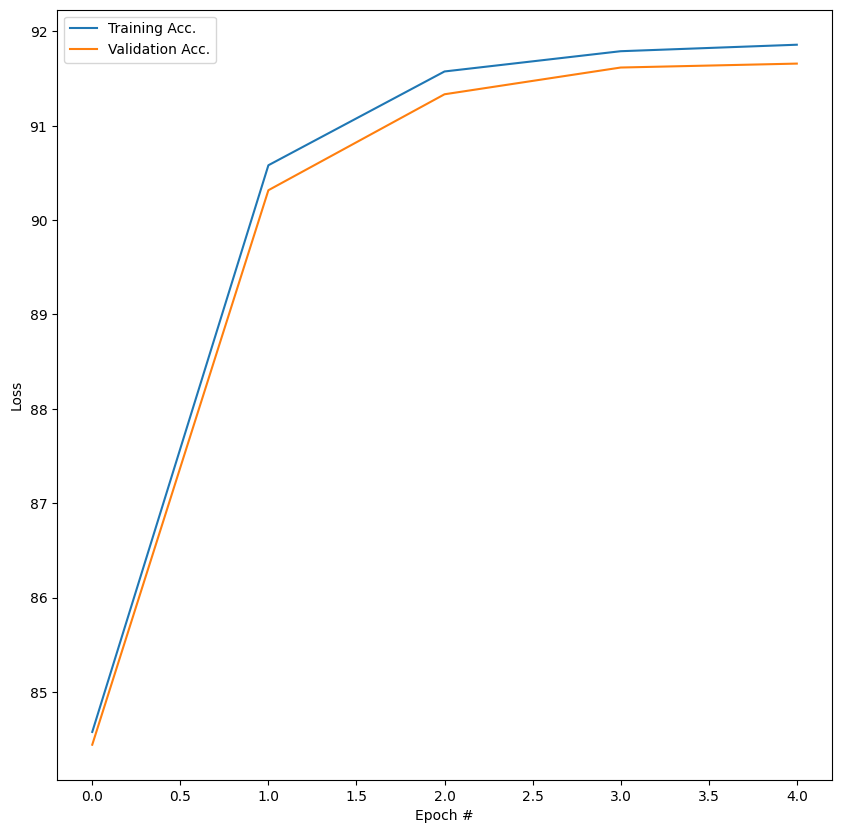

In [24]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


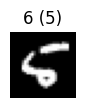

In [25]:
show_failures(nonlinear_model, test_dataloader)

In [26]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print(f"Test loss: {loss_test:.4f}, Test accuracy: {acc_test:.2f}%")

Test loss: 0.2783, Test accuracy: 92.09%


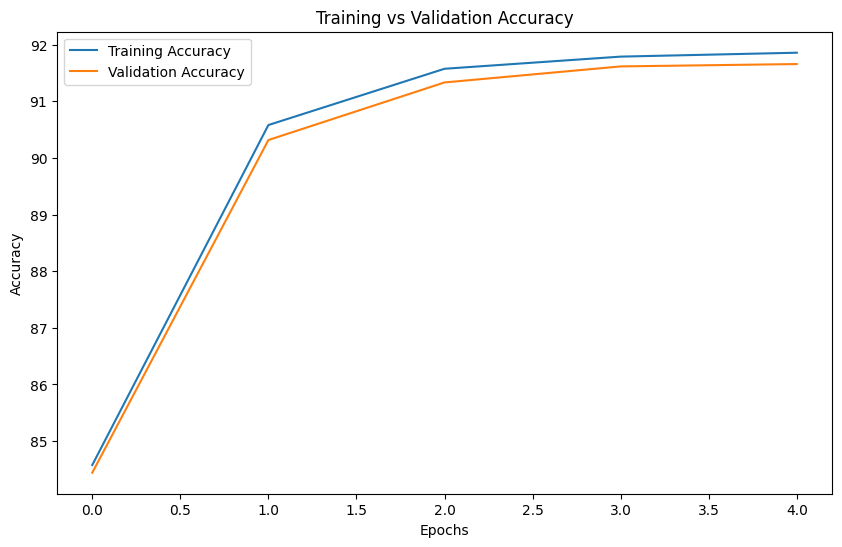

In [28]:
# Plot training vs validation accuracy for different configurations
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_acc_all, label='Training Accuracy')
plt.plot(range(epochs), val_acc_all, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()